# Daily website visitors analysis and Forecasting

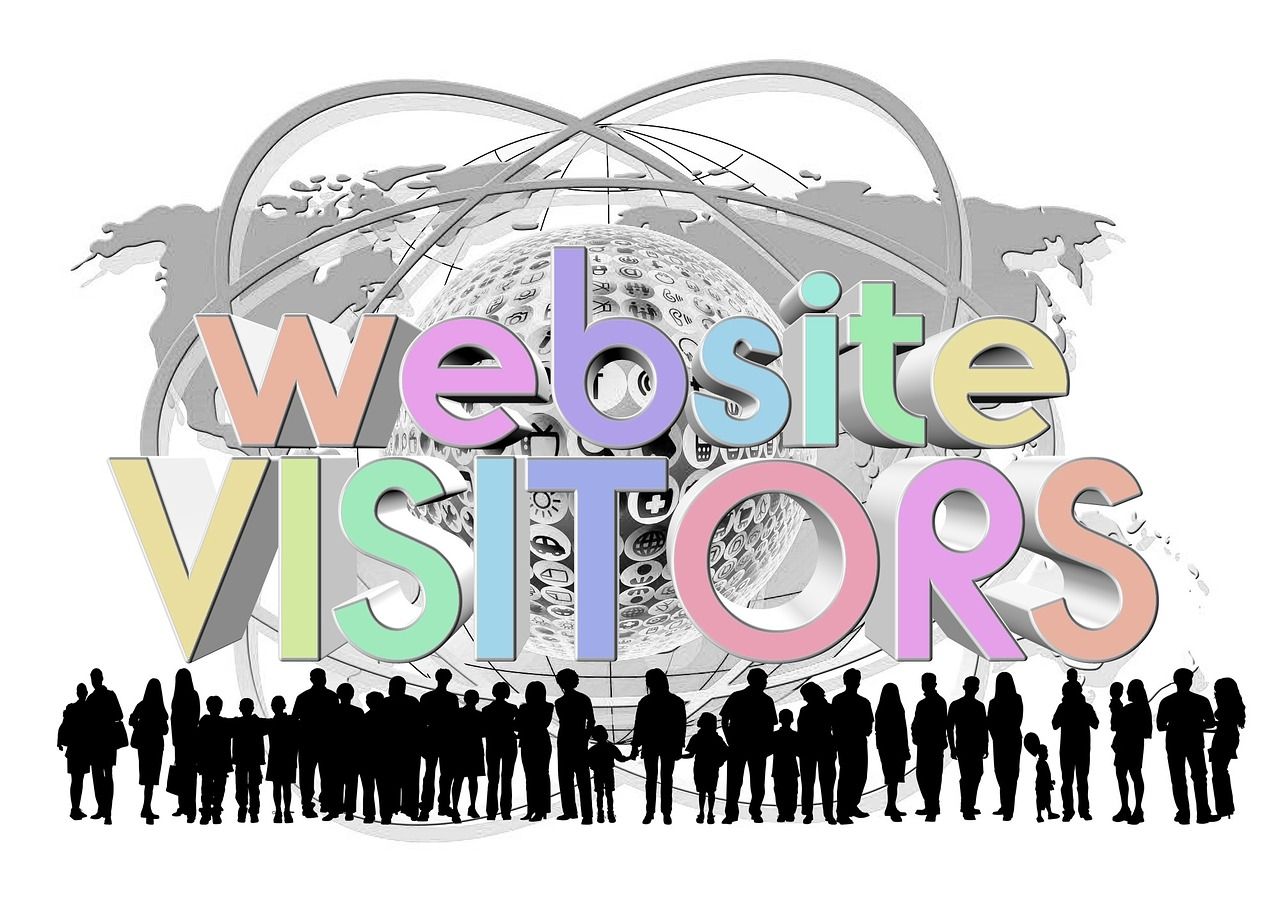

In [1]:
from IPython.display import Image
Image(filename='website.jpg', width=800, height=500)


<a id="cont"></a>
# Table of content

<a href=#one>1. Objectives</a> 

<a href=#two>2. Importing Libraries</a>

<a href=#three>3. Data Collection</a>

<a href=#four>4. Preprocessing</a>

<a href=#five>5. Exploratory data Analysis</a>

<a href=#six>6. Feature Engineering</a>

<a href=#seven>7. modeling</a>

<a href=#eight>8. Model review</a>

<a href=#nine>9. Forecasting</a>

<a id="one"></a>
# 1. Objectives
<a href=#cont>Back to Table of Contents</a>

The objective of this project is to  gain insights into the traffic patterns and user behavior on an academic teaching notes website over a six-year period, from September 14, 2014, to August 19, 2020. It aims to explore trends, patterns, and relationships within the dataset to provide valuable insights into user engagement and traffic fluctuations. This project also aims to develop the model that forecast the website traffic. 


**Definition of a Visit**: A visit is characterized by a stream of hits on one or more pages of the website by the same user, as identified by their IP address. It's important to note that multiple individuals sharing a single IP address (e.g., in a computer lab) are considered a single user in this analysis. This approach acknowledges that real users may be undercounted to some extent.

**Unique Visits**: A visit is classified as "unique" if a hit from the same IP address has not occurred within the last 6 hours. This definition helps differentiate between distinct visits from the same user.

**Returning Visitors**: Returning visitors are identified through cookies, provided they are accepted. These are users who have visited the website before and are returning for another session.

**First-Time Visitors**: All other visits that do not meet the criteria for returning visitors are classified as first-time visitors. Therefore, the count of unique visitors is the sum of both returning and first-time visitors, following this definition.


<a id="two"></a>
# 2. Importing Libraries
<a href=#cont title='takes you back to table of content'> Back to Table of Contents</a>

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from xgboost import XGBRegressor 
from prophet import Prophet
import warnings
warnings.simplefilter('ignore')

<a id="three"></a>
# 3. Collecting data
<a href=#cont title='takes you back to table of content'> Back to Table of Contents</a>

In [3]:
#Reading the data into a dataframe
df=pd.read_csv('daily-website-visitors.csv')
#Viewing the head of the data
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


<a id="four"></a>
# 4. Preprocessing
<a href=#cont title='takes you back to table of content'> Back to Table of Contents</a>

**Information on the dataframe**

In [4]:
## Showing  data set information
def features_attributes(df):
    df1=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        top_value =df[col].mode()[0]
        df1.append([col,dtypes,nunique,sum_null, top_value])
    df1=pd.DataFrame(df1)
    df1.columns=['Feature names','data types','number of unique','sum of null values', 'Top value']
    return df1 
features_attributes(df)

,Feature names,data types,number of unique,sum of null values,Top value
0,Row,int64,2167,0,1
1,Day,object,7,0,Monday
2,Day.Of.Week,int64,7,0,1
3,Date,object,2167,0,1/1/2015
4,Page.Loads,object,1756,0,"2,948"
5,Unique.Visits,object,1658,0,"1,197"
6,First.Time.Visits,object,1587,0,"3,133"
7,Returning.Visits,object,663,0,552


**Changing the features datatype**

In [5]:
#Converting the features  into integers 
cols_to_convert = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']

for col in cols_to_convert:
    df[col] = df[col].str.replace(',', '').astype(int)

df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278
3,4,Wednesday,4,9/17/2014,3667,2614,2327,287
4,5,Thursday,5,9/18/2014,3316,2366,2130,236


**Extracting Year, Months and day features**

In [6]:
# Spliting  the Date column into'Year', 'Month', 'Day' columns
df[['Month', 'Days', 'Year']] = df['Date'].str.split('/', expand=True)
# Converting 'Month' column to integers 
df['Month'] = df['Month'].astype(int)
# Converting 'Day' column to integers 
df['Days'] = df['Days'].astype(int)
# Converting 'Year' column to integers
df['Year'] = df['Year'].astype(int)

**Changing the date column into datetime and setting it as an index**

In [7]:
#Converting the data column into datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
#Setting date as index
df['date']=df['Date']
df.set_index('date', inplace=True)
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Days,Year
date,,,,,,,,,,,
2014-09-14,1,Sunday,1,2014-09-14,2146,1582,1430,152,9,14,2014
2014-09-15,2,Monday,2,2014-09-15,3621,2528,2297,231,9,15,2014
2014-09-16,3,Tuesday,3,2014-09-16,3698,2630,2352,278,9,16,2014
2014-09-17,4,Wednesday,4,2014-09-17,3667,2614,2327,287,9,17,2014
2014-09-18,5,Thursday,5,2014-09-18,3316,2366,2130,236,9,18,2014


<a id="five"></a>
# 5. Exploratory Data Analysis
<a href=#cont title='takes you back to table of content'> Back to Table of Contents</a>

**5.1 Time Series of the website visits over a period of five years**

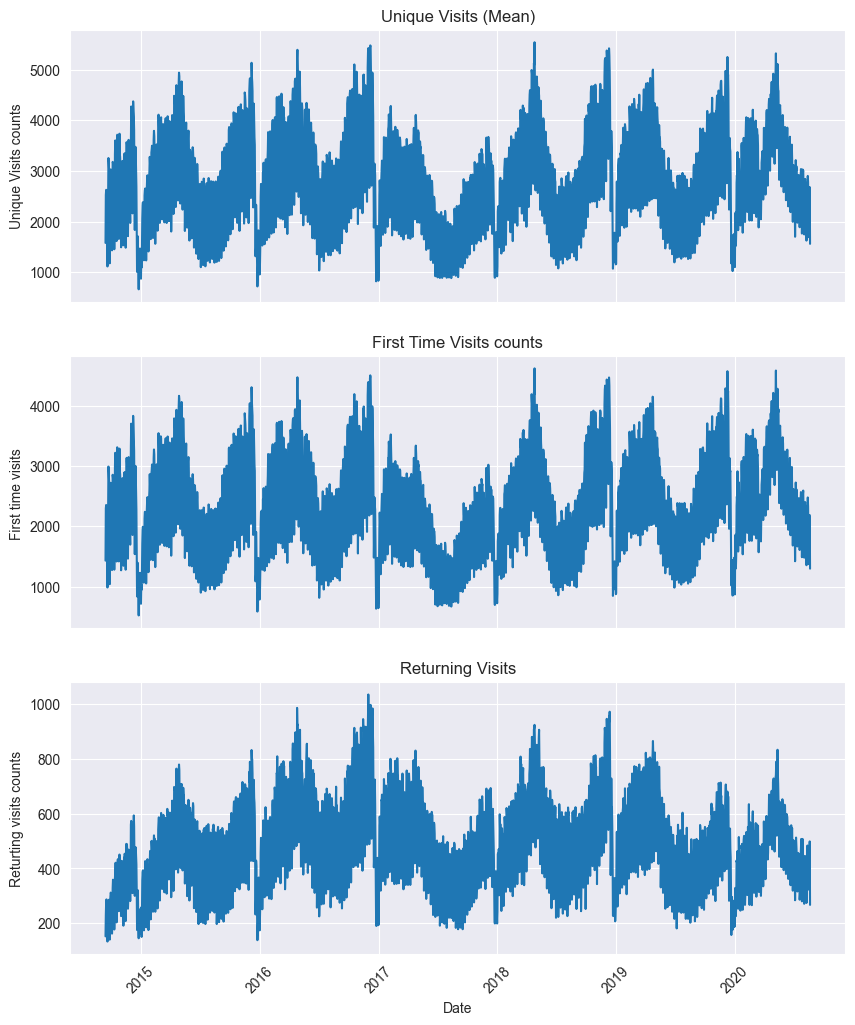

In [8]:
sns.set_style("darkgrid")  
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
sns.lineplot(data=df, x='Date', y='Unique.Visits',  ax=axs[0])
axs[0].set_title("Unique Visits (Mean)")
axs[0].set_xlabel("")
axs[0].set_ylabel("Unique Visits counts")
sns.lineplot(data=df, x='Date', y='First.Time.Visits', ax=axs[1])
axs[1].set_title("First Time Visits counts")
axs[1].set_xlabel("")
axs[1].set_ylabel("First time visits ")
sns.lineplot(data=df, x='Date', y='Returning.Visits', ax=axs[2])
axs[2].set_title("Returning Visits")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Returting visits counts")

plt.xticks(rotation=45)  
plt.show()

**Observation**

- Most of the unique visits are attributed to first-time visitors rather than returning visits. Returning visits fall within a range of 133 to 1,036 unique visits, while first-time visits have a broader range, spanning from more than 522 to 4,616 unique visits.

**5.2 Bar Graph of the avearge of a yearly unique visits**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


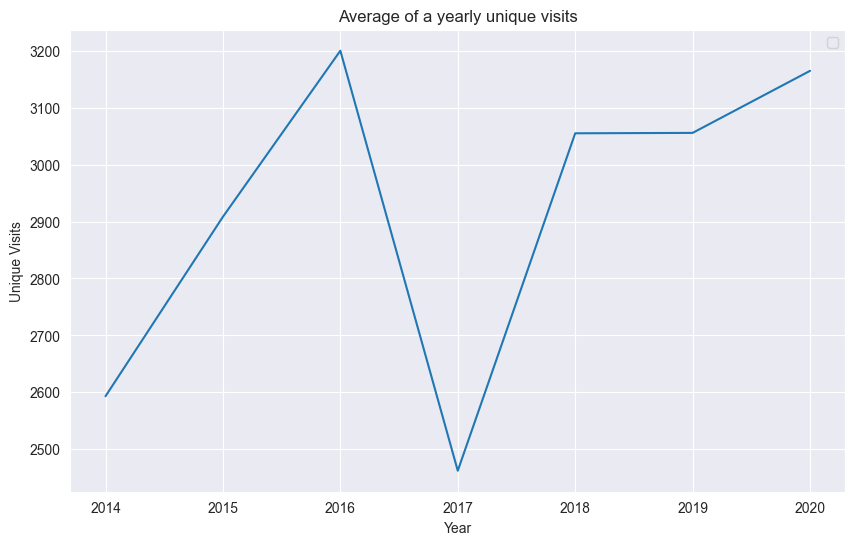

In [10]:
df_mon=df[['Year', 'Unique.Visits']].groupby('Year').agg('mean')
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_mon.index,  y=df_mon['Unique.Visits'])
plt.xlabel('Year')
plt.ylabel('Unique Visits')
plt.title('Average of a yearly unique visits')
plt.legend()
plt.show()

**Observations**

- From 2014 to early 2016, there was a notable increase in the number of unique visitors to the website. However, as the year 2016 progressed, the average unique visits began to decline. This decline continued until 2017, when the number of visitors started to rise again.

- The peak average of unique website visitors occurred in early 2016, reaching a value of 3,200.

**5.3 Line plot of the average monthly unique visits**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


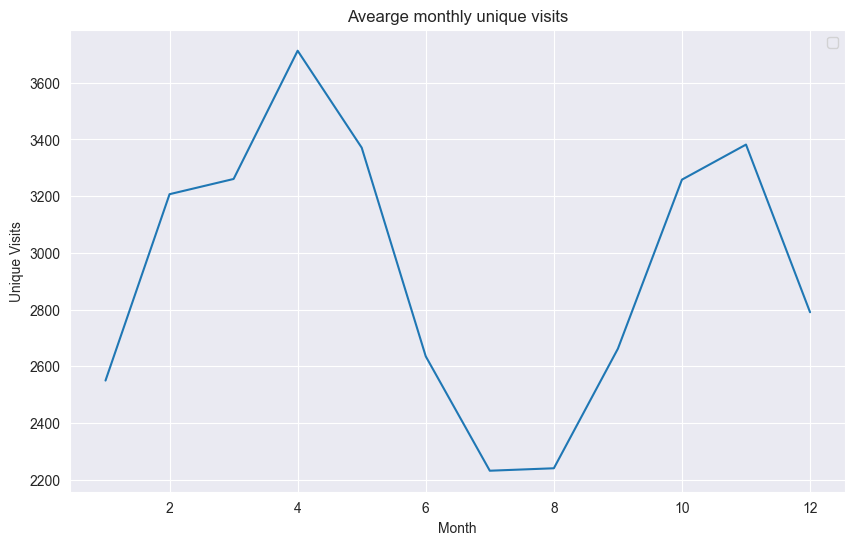

In [11]:
df_mon=df[['Month', 'Unique.Visits']].groupby('Month').agg('mean')
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_mon.index,  y=df_mon['Unique.Visits'])
plt.xlabel('Month')
plt.ylabel('Unique Visits')
plt.title('Avearge monthly unique visits')
plt.legend()
plt.show()

**Observation**

- In the early months  of the year , there was a notable increase in the number of student visitors. However, as the year approached midyear, there was a decline in website traffic among students. After the midyear, there was a resurgence in the number of unique visitors, although they did not reach the peak of 3,600 observed in the initial months.

**5.4 Bar graph of the avearge unique visits and page loads***

Text(0, 0.5, 'Day')

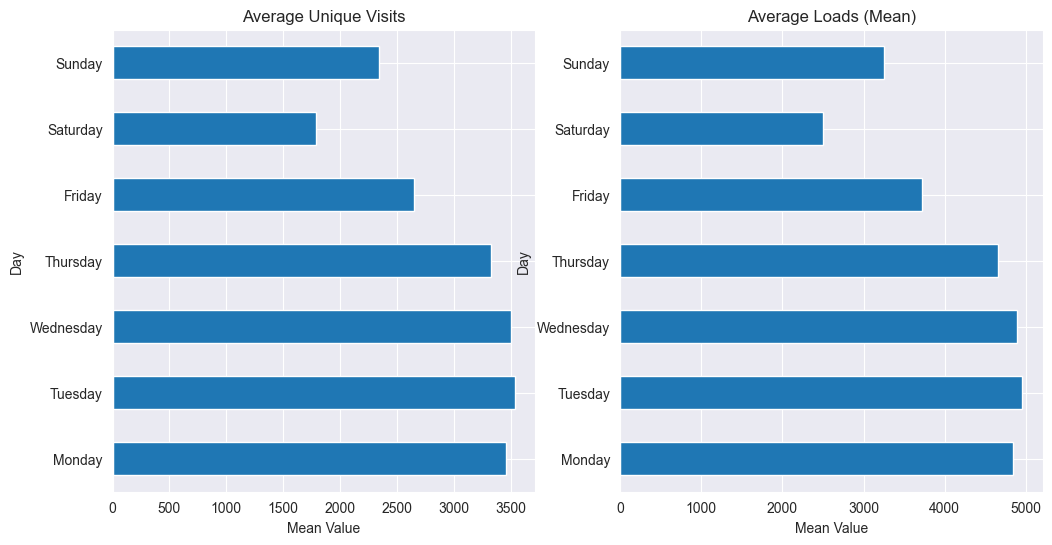

In [12]:
# Creating a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Converting the 'Day' column to a categorical data type with the custom order
DF = df.groupby("Day").agg({ 'Page.Loads': "mean", 'Unique.Visits': "mean"})
#Reordering the days of the week
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
DF = DF.loc[custom_order]
#Setting up a plot fot Average Page Loads
DF['Page.Loads'].plot(kind='barh', ax=axs[1])
axs[1].set_title("Average Loads (Mean)")
axs[1].set_xlabel("Mean Value")
axs[1].set_ylabel("Day")
#Setting up a plot fot Average Unique Visits 
DF['Unique.Visits'].plot(kind='barh', ax=axs[0])
axs[0].set_title("Average Unique Visits")
axs[0].set_xlabel("Mean Value")
axs[0].set_ylabel("Day")

**Observation**

- The majority of website visits occur between Monday and Thursday, with a noticeable decrease on Friday and Saturday. While there is a slight increase in traffic on Sundays, it doesn't reach the same level as the average traffic observed from Monday to Thursday.

**5.6 Auto Correlation and partial auto correlation Plot**

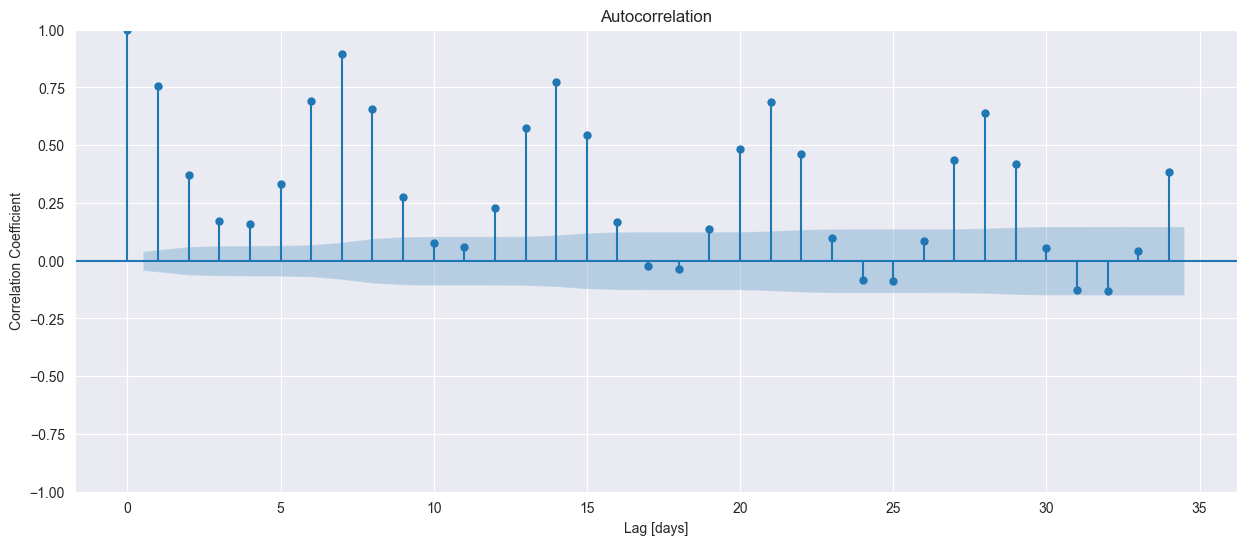

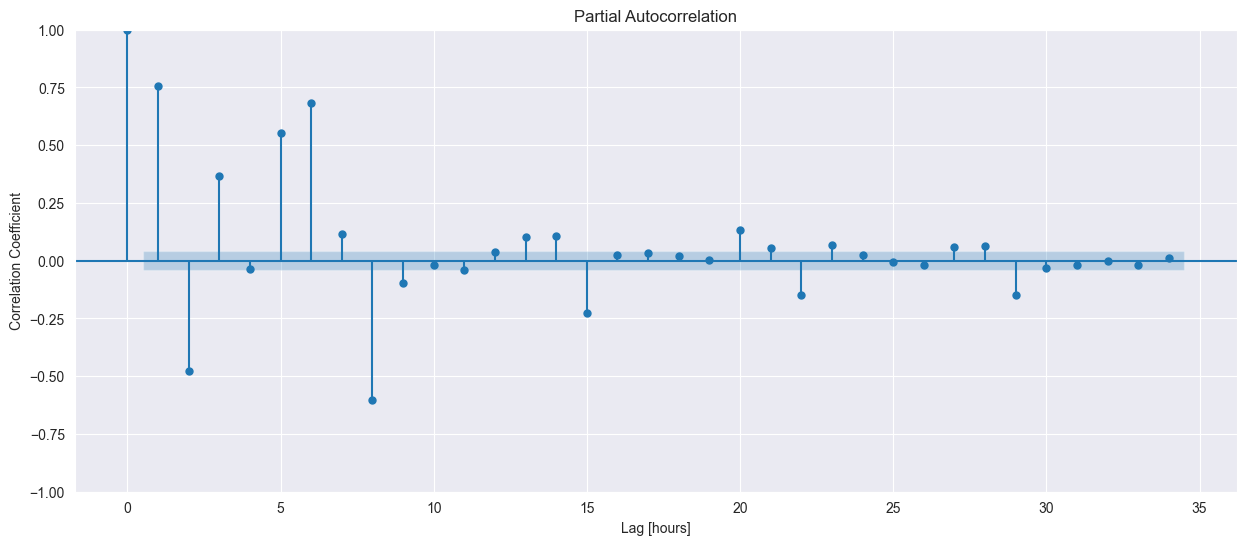

In [13]:
#Setting up the figure
fig, ax = plt.subplots(figsize=(15, 6))
#Plotting 
plot_acf(df['Unique.Visits'], ax=ax)
#Labeling the 
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.show();

#Setting up the figure
fig, ax = plt.subplots(figsize=(15, 6))
#Plotting
plot_pacf(df['Unique.Visits'], ax=ax)
#Labelling the axis 
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.show;

<a id="six"></a>
# 6. Feature Engineering
<a href=#cont title='takes you back to table of content'> Back to Table of Contents</a>

**Data sets for Prophet model**

In [14]:
fdf=df
#Masking the columns of interest
fdf=fdf[['Unique.Visits', 'Date']]
cutoff_test = int(len(fdf)*0.95)
#Subseting the data
y_train_prop = fdf.iloc[:cutoff_test]
y_test_prop = fdf.iloc[cutoff_test:]
#Converting the data into a dataframe
y_train_prop = pd.DataFrame(y_train_prop)
#Renaming the data as per prerequisite of the model 
y_train_prop=y_train_prop.rename(columns={'Unique.Visits':'y', 'Date': 'ds'})
y_train_prop.head()

,y,ds
date,,
2014-09-14,1582,2014-09-14
2014-09-15,2528,2014-09-15
2014-09-16,2630,2014-09-16
2014-09-17,2614,2014-09-17
2014-09-18,2366,2014-09-18


**Preparing the dataset of Xgbooster and Linear Regression**

In [15]:
df_xl=df
#Masking the data of interest
df_xl=df_xl[["Unique.Visits", 'Page.Loads', 'Day.Of.Week', 'Days', 'Month', 'Row' , 'First.Time.Visits', 'Returning.Visits' ]]

#Generating data by shifting the previous observation as the X varaibles
n_shifts = 30 # Number of shifts you want to create
for i in range(1, n_shifts + 1):
    df_xl[f"Unique.lag{i}"] = df_xl["Unique.Visits"].shift(i)
#Shifting the page loads column
df_xl["page.lag"]=df_xl["Page.Loads"].shift(1)
#Dropping the rows with null values
df_xl.dropna().head()

,Unique.Visits,Page.Loads,Day.Of.Week,Days,Month,Row,First.Time.Visits,Returning.Visits,Unique.lag1,Unique.lag2,...,Unique.lag22,Unique.lag23,Unique.lag24,Unique.lag25,Unique.lag26,Unique.lag27,Unique.lag28,Unique.lag29,Unique.lag30,page.lag
date,,,,,,,,,,,,,,,,,,,,,
2014-10-14,3604,5040,3,14,10,31,3217,387,3339.0,2089.0,...,2586.0,1656.0,1118.0,1863.0,2366.0,2614.0,2630.0,2528.0,1582.0,4814.0
2014-10-15,3515,5028,4,15,10,32,3094,421,3604.0,3339.0,...,3257.0,2586.0,1656.0,1118.0,1863.0,2366.0,2614.0,2630.0,2528.0,5040.0
2014-10-16,3331,4658,5,16,10,33,2955,376,3515.0,3604.0,...,3175.0,3257.0,2586.0,1656.0,1118.0,1863.0,2366.0,2614.0,2630.0,5028.0
2014-10-17,2477,3624,6,17,10,34,2148,329,3331.0,3515.0,...,3029.0,3175.0,3257.0,2586.0,1656.0,1118.0,1863.0,2366.0,2614.0,4658.0
2014-10-18,1619,2285,7,18,10,35,1416,203,2477.0,3331.0,...,2249.0,3029.0,3175.0,3257.0,2586.0,1656.0,1118.0,1863.0,2366.0,3624.0


**Variables**

In [16]:
#Predictors*
X=df_xl[(df_xl.drop(columns=['Unique.Visits','Page.Loads', 'Returning.Visits', 'First.Time.Visits', 'Row'], axis=1)).columns]
#response variable 
y=df_xl['Unique.Visits']


**Standard Scaler**

In [17]:
# building the standard scalar 
scaler =MinMaxScaler()
#Fitting and transaforming the data
x= scaler.fit_transform(X)
#Converting the data into dataframe 
X=pd.DataFrame(X, columns=X.columns)

**spliting the data**

In [18]:
#Cutoff og 80% 
cutoff1 = int(len(X)*0.8)
#training data
X_train_xl, y_train_xl = X.iloc[30:cutoff1], y.iloc[30:cutoff1]
#Testing data
X_test_xl, y_test_xl =X.iloc[cutoff1:], y.iloc[cutoff1:]

**Preparing the dataset of AR model**

In [19]:
df_AR=df
#Setting time colum as an index
df_AR.set_index(df_AR['Date'], inplace=True)
#Setting the up the response variable
y=df_AR['Unique.Visits']
#Spliting the data into training and testing data
cutoff_test = int(len(y)*0.95)
y_train_AR = y.iloc[:cutoff_test]
y_test_AR = y.iloc[cutoff_test:]

<a id="seven"></a>
# 7. Modeling
<a href=#cont title='takes you back to table of content'> Back to Table of Contents</a>

**Facebook Prophet**

In [20]:
#Building the model
proph = Prophet(interval_width=0.95, daily_seasonality=True)
# Training the model
proph.fit(y_train_prop)

12:16:06 - cmdstanpy - INFO - Chain [1] start processing
12:16:07 - cmdstanpy - INFO - Chain [1] done processing


**XGB Regressor**

In [21]:
#Buidling the model
xgbr=XGBRegressor(n_estimators=60, max_depth=5, learning_rate=0.05, gamma=0.1)
#Training the model
xgbr.fit(X_train_xl, y_train_xl)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=60, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

**AutoRegressive model**

In [22]:
#Building the model
AR =AutoReg(y_train_AR, lags=29).fit()

**Linear Regression**

In [23]:
#Building the model
lr = LinearRegression()
#Fitting the model
lr.fit(X_train_xl, y_train_xl)

LinearRegression()

<a id="eight"></a>
# 8. Model Review
<a href=#cont title='takes you back to table of content'> Back to Table of Contents</a>

**Prophet Model**

Predicting using Prophet model

In [24]:
#Making future Predictions
future = proph.make_future_dataframe(periods=109,freq='D')
forecast = proph.predict(future)
#spliting the forecast to train and test data predictions
y_pred=forecast['yhat'].tail(2058)
y_preds=forecast['yhat'].tail(109)

Mean Absolute error

In [25]:
#Calculating the mean absolute error on the training data
training_mae = mean_absolute_error(y_train_prop['y'], y_pred)
#Printing
print("Training MAE:", training_mae)
#Calculating the mean absolute error on the testing data
testing_mae = mean_absolute_error(y_test_prop['Unique.Visits'], y_preds)
#printing
print("Testing MAE:", testing_mae)

Training MAE: 1358.1806313326683
Testing MAE: 577.9101877720516


**XGBRegressor**

In [26]:
pred = xgbr.predict(X_train_xl)
training_mae = mean_absolute_error(y_train_xl, pred)
print("Training MAE:", training_mae)
preds=xgbr.predict(X_test_xl)
testing_mae = mean_absolute_error(y_test_xl,preds)
print("Testing MAE:", testing_mae)

Training MAE: 176.14453963651002
Testing MAE: 226.4748785484771


**AutoRegressive Model**

In [27]:
y_pred = AR.predict().dropna()
training_mae = mean_absolute_error(y_train_AR.iloc[29:],y_pred)
print("Training MAE:", training_mae)
y_pred_test = AR.predict(y_test_AR.index.min(),y_test_AR.index.max())
test_mae = mean_absolute_error(y_test_AR, y_pred_test)
print("Testing MAE:", test_mae)

Training MAE: 166.87799275598508
Testing MAE: 368.32319305835654


**Linear Regression**

In [28]:
pred = lr.predict(X_train_xl)
training_mae = mean_absolute_error(y_train_xl, pred)
print("Training MAE:", training_mae)
preds=lr.predict(X_test_xl)
testing_mae = mean_absolute_error(y_test_xl,preds)
print("Testing MAE:", testing_mae)

Training MAE: 159.041005564977
Testing MAE: 176.91348224541008


**Best Model**

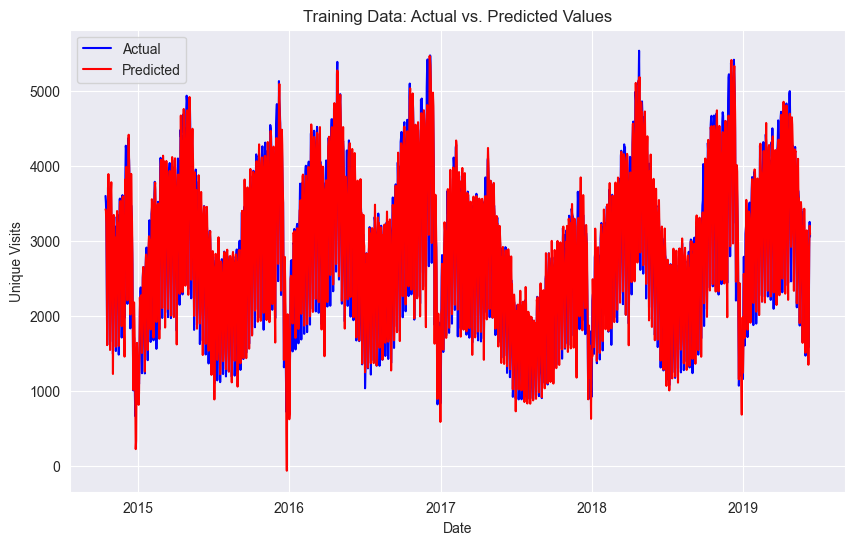

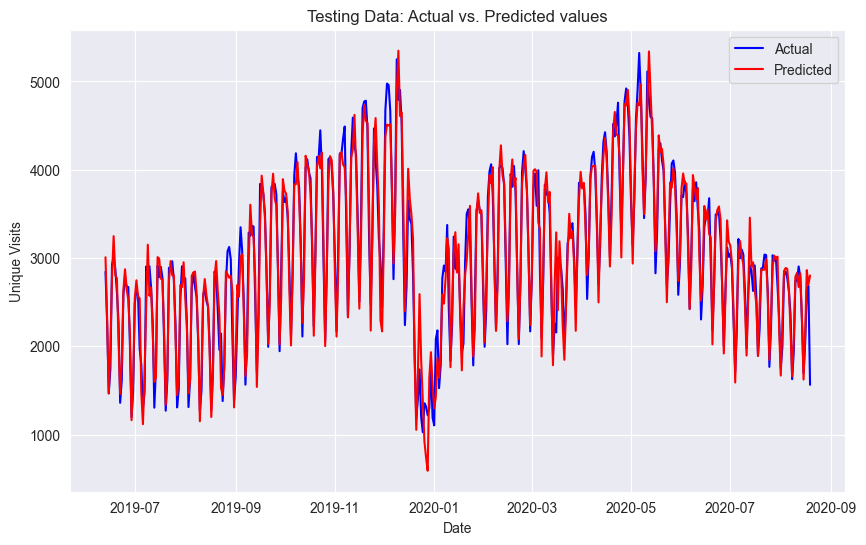

In [29]:
# Plot for training data
plt.figure(figsize=(10, 6))
sns.lineplot( x=y_train_xl.index, y=y_train_xl, label='Actual', color='blue')
sns.lineplot( x=y_train_xl.index, y=pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.title('Training Data: Actual vs. Predicted Values')
plt.legend()
plt.show()

# Plot for testing data (assuming you have 'df_pred_test' and 'y_test_xl')
plt.figure(figsize=(10, 6))
sns.lineplot( x=y_test_xl.index, y=y_test_xl, label='Actual', color='blue')
sns.lineplot(x=y_test_xl.index, y=preds, label='Predicted', color='Red')
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.title('Testing Data: Actual vs. Predicted values')
plt.legend()
plt.show()